### Vehicle Detection Project

**The goals / steps of this project are the following:**

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.

Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

**Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier**

In [78]:
## Tips:
# Make sure your images are scaled correctly
# The training dataset provided for this project 
# (vehicle and non-vehicle images) are in the .png format. 
# Somewhat confusingly, matplotlib image will read these in on a scale of 0 to 1, 
# but cv2.imread() will scale them from 0 to 255. 

# Be sure if you are switching between cv2.imread() 
# and matplotlib image for reading images that you scale them appropriately! 
# Otherwise your feature vectors can get screwed up.

# To add to the confusion, matplotlib image will read .jpg images in on a scale of 0 to 255 
# so if you are testing your pipeline on .jpg images remember to scale them accordingly. 
# And if you take an image that is scaled from 0 to 1 

# and change color spaces using cv2.cvtColor() 
# you'll get back an image scaled from 0 to 255. 
# So just be sure to be consistent between your training data features and inference features!

# image = mpimg.imread('vehicles/bbox-example-image.jpg') ## scale of 0-255 for .jpg, scale of 0-1 for .png


In [80]:
import sklearn
import skimage
print('The scikit-learn version: {}.'.format(sklearn.__version__))
print('The scikit-image version: {}.'.format(skimage.__version__))


The scikit-learn version: 0.18.2.
The scikit-image version: 0.13.0.


In [79]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [81]:
# skimage libs
from skimage.feature import hog 
# sklearn libs
from sklearn.svm import LinearSVC # SVM 
from sklearn import tree # Decision tree
from sklearn.preprocessing import StandardScaler # data generalization
from sklearn.model_selection import train_test_split # for >= v0.18.
# label
from scipy.ndimage.measurements import label
# misc. libs
import numpy as np
import cv2
import glob
import pickle
# matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
car_images = glob.glob('trainingdataset/vehicles/**/*.png')
noncar_images = glob.glob('trainingdataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


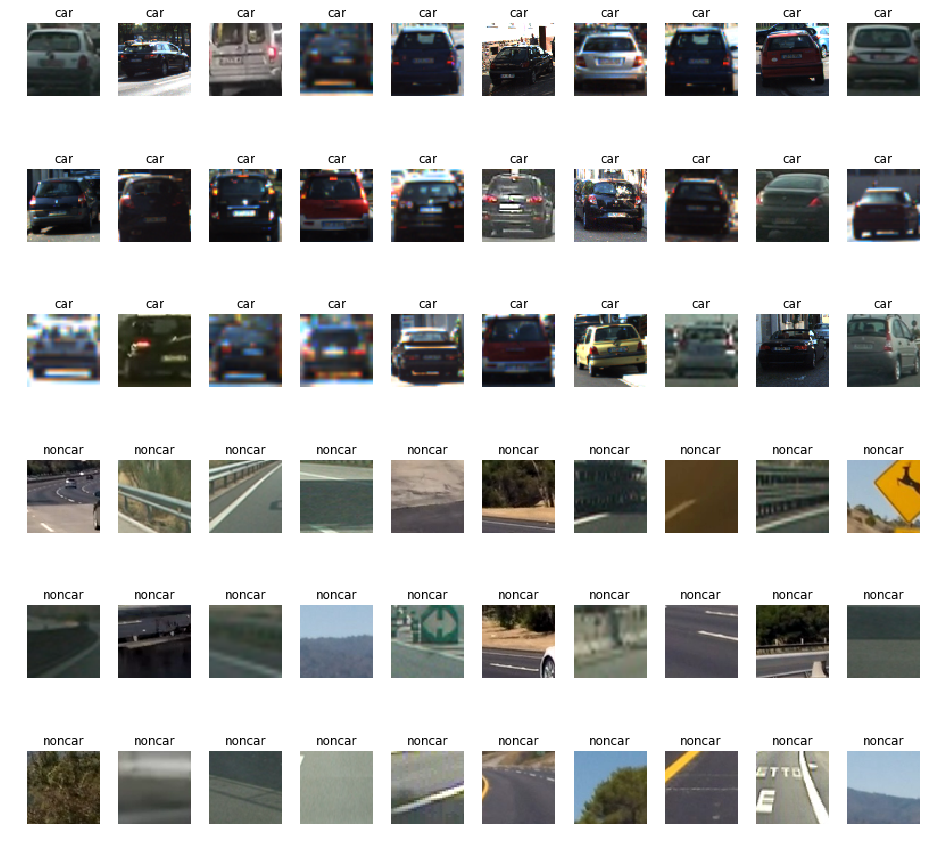

In [6]:
# data exploration

# car images
fig, ax = plt.subplots(6, 10, figsize=(16, 16))
fig.subplots_adjust(hspace = .025, wspace=.25)
ax = ax.ravel()
for idx in range(30):
    image = cv2.imread(car_images[np.random.randint(0,len(car_images))]) # scale of 0-255
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # 0-255 scale
    ax[idx].axis('off')
    ax[idx].set_title('car', fontsize=12)
    ax[idx].imshow(image)

# noncar images
for idx in range(30,60):
    image = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))]) # scale of 0-255
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # 0-255 scale
    ax[idx].axis('off')
    ax[idx].set_title('noncar', fontsize=12)
    ax[idx].imshow(image)


In [82]:
# Histogram of oriented gradients (HOG)
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features


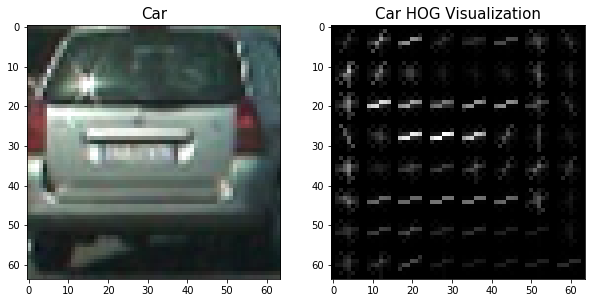

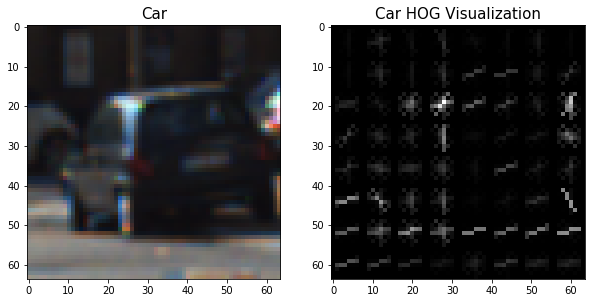

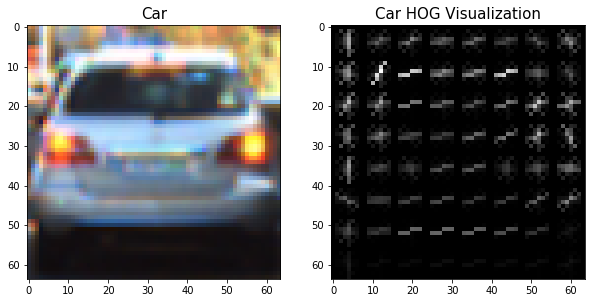

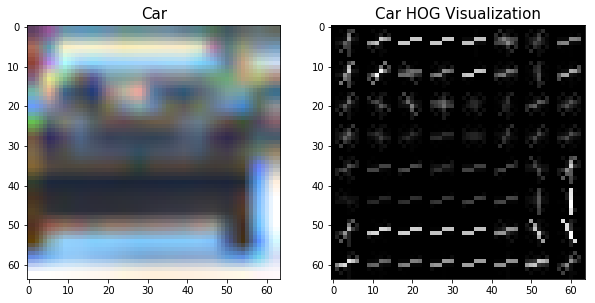

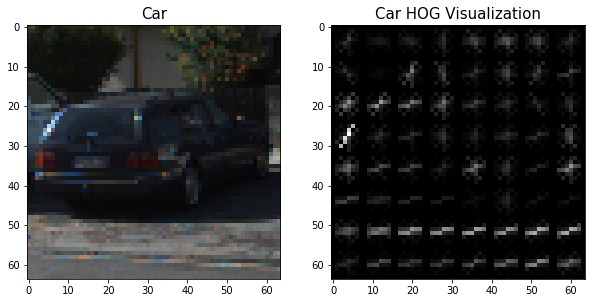

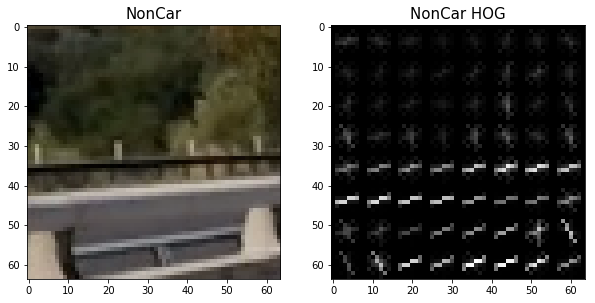

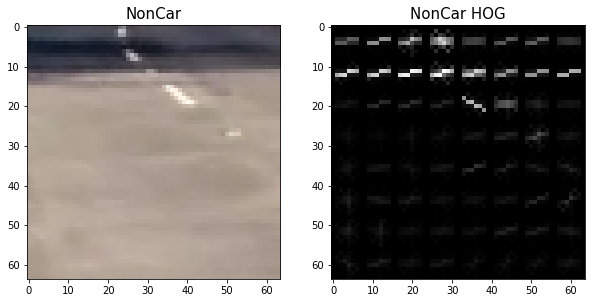

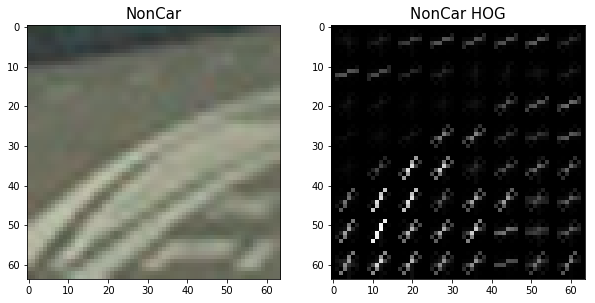

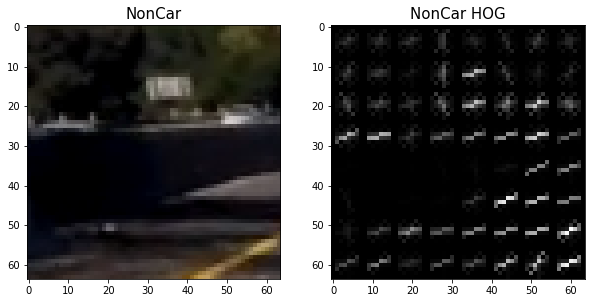

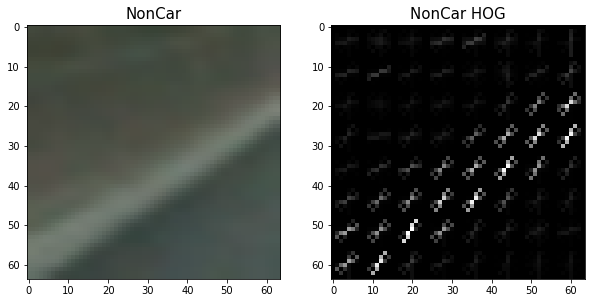

(7, 7, 2, 2, 9)
(64, 64)


In [83]:
orient = 9 
pix_per_cell = 8
cell_per_block = 2

for idx in np.arange(5):
    # car
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

    # visualization
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Car', fontsize=15)
    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title('Car HOG Visualization', fontsize=15)        
    plt.show()


for idx in np.arange(5):
    # car
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    
    # visualization
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('NonCar', fontsize=15)
    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title('NonCar HOG', fontsize=15)        
    plt.show()

print(features.shape)
print(hog_image.shape)

**Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.**


In [84]:
# # Define a function to compute binned color features  
# def bin_spatial(img, size=(32, 32)):
#     features = cv2.resize(img, size).ravel() # create the feature vector
#     return features

# # Define a function to compute color histogram features  
# def color_hist(img, nbins=32, bins_range=(0, 256)):
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0])) # Concatenate the histograms into a single feature vector
#     return hist_features

### Extract HOG features from an array.
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), orient=9, pix_per_cell=8, cell_per_block=2,
                         hist_bins=32, hist_range=(0, 256), hog_feature=True, hog_channel=0):
    
    features = [] # list to append feature vectors
    for eachimg in imgs: # Iterate through the list of images
        img = mpimg.imread(eachimg) # Read in each one by one
        if cspace != 'RGB': # apply color conversion if other than 'RGB'
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img) 
        
        # HOG features (vis=False; features_vector=True)
        if hog_channel == 'ALL':
            hog_features = [] # list of hog features
            for channel in range(feature_image.shape[2]): # color channels
                hog_ft = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                hog_features.append(hog_ft)
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_features)
        
        ## Note: combining HOG+spatial+hist needs a powerful PC to run, otherwise, HOG is only used.
        ## Tried to combine three of them on Macbookpro, crashed!
        
        # spatial feature
        # if spatial_feature == True:
        
        # feature_spatial_color = bin_spatial(feature_image, size=spatial_size) # Apply bin_spatial() to get spatial color features
        # features.append(feature_spatial_color)
            
        # histogram feature
        # if hist_feature == True:    
        #     feature_histogram_color = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range) # Apply color_hist() to get color histogram features
        #     features.append((feature_histogram_color))
            
        # features.append(np.concatenate(features))
    return features


In [76]:
import time
## feature extraction parameters exploration
color_space = ['RGB', 'HSV', 'HLS', 'LUV', 'YUV', 'YCrCb']
hog_channel = [2, 'ALL']
orient = [8, 11]
pix_per_cell = [8, 12, 16]
cell_per_block = 2

for eCS in color_space:
    for eHC in hog_channel:
        for eOR in orient:
            for ePX in pix_per_cell:
                print('>>>>')
                print('Color Space: ', eCS, '; HOG channel: ', eHC, '; Orient: ', eOR, '; Pix per cell: ', ePX,' ;')
                
                t = time.time()
                car_features = extract_features(car_images, cspace=eCS, spatial_size=(32, 32), orient=eOR, pix_per_cell=ePX, cell_per_block=cell_per_block, hist_bins=32, hist_range=(0, 256), hog_feature=True, hog_channel=eHC)
                noncar_features = extract_features(noncar_images, cspace=eCS, spatial_size=(32, 32), orient=eOR, pix_per_cell=ePX, cell_per_block=cell_per_block, hist_bins=32, hist_range=(0, 256), hog_feature=True, hog_channel=eHC)
                t1 = time.time()
                
                print('It takes', round(t1-t, 5), 'seconds to extract HOG features.')
                print('Car Features: ', len(car_features))
                print('NonCar Features: ', len(noncar_features))
                
    print('<<<<')


>>>>
Color Space:  RGB ; HOG channel:  2 ; Orient:  8 ; Pix per cell:  8  ;
It takes 30.5448 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  RGB ; HOG channel:  2 ; Orient:  8 ; Pix per cell:  12  ;
It takes 22.87939 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  RGB ; HOG channel:  2 ; Orient:  8 ; Pix per cell:  16  ;
It takes 21.77754 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  RGB ; HOG channel:  2 ; Orient:  11 ; Pix per cell:  8  ;
It takes 34.036 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  RGB ; HOG channel:  2 ; Orient:  11 ; Pix per cell:  12  ;
It takes 23.02448 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  RGB ; HOG channel:  2 ; Orient:  11 ; Pix per cell:  16  ;
It takes 22.21846 seconds to extract HOG features.
Car Features:  8792

It takes 28.5655 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  YUV ; HOG channel:  2 ; Orient:  8 ; Pix per cell:  12  ;
It takes 21.32812 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  YUV ; HOG channel:  2 ; Orient:  8 ; Pix per cell:  16  ;
It takes 22.29023 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  YUV ; HOG channel:  2 ; Orient:  11 ; Pix per cell:  8  ;
It takes 31.1985 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  YUV ; HOG channel:  2 ; Orient:  11 ; Pix per cell:  12  ;
It takes 24.73312 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  YUV ; HOG channel:  2 ; Orient:  11 ; Pix per cell:  16  ;
It takes 22.23977 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968
>>>>
Color Space:  YUV ; HOG channel:  ALL ; Orient

In [85]:
import time
## Extract the features
color_space = 'YUV' # RGB, HSV, HLS, LUV, YUV, YCrCb
hog_channel = 'ALL' # 0, 1, 2, ALL
orient = 11
pix_per_cell = 16
cell_per_block = 2

t = time.time()

car_features = extract_features(car_images, cspace=color_space, spatial_size=(32, 32), orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hist_bins=32, hist_range=(0, 256), hog_feature=True, hog_channel=hog_channel)
noncar_features = extract_features(noncar_images, cspace=color_space, spatial_size=(32, 32), orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hist_bins=32, hist_range=(0, 256), hog_feature=True, hog_channel=hog_channel)

t1 = time.time()

print('It takes', t1-t, 'seconds to extract HOG features.')
print('Car Features: ', len(car_features))
print('NonCar Features: ', len(noncar_features))

It takes 48.919174909591675 seconds to extract HOG features.
Car Features:  8792
NonCar Features:  8968


In [86]:
# features vector array
if (len(car_features)>0):
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    
    # in case of HOG + spatial + histogram
    #X_scaler = StandardScaler().fit(X) # Fit a per-column scaler: 
    #scaled_X = X_scaler.transform(X) # Apply the scaler to X

    # labels vector
    y = np.hstack(( np.ones(len(car_features)), np.zeros(len(noncar_features)) ))

    # splitting 80-20 and shuffling data
    rand_num = np.random.randint(0, len(car_images))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_num)
    
    # display
    print('Using orient: ', orient, '; pixel per cell: ', pix_per_cell, '; cell_per_block: ', cell_per_block)
    
    print('Features vector length of X_train: ', len(X_train))
    print('Features vector length of X_test: ', len(X_test))
    print('Features vector length of y_train: ', len(y_train))
    print('Features vector length of y_test: ', len(y_test))
    
else:
    print('Oops! Features size is empty!')


Using orient:  11 ; pixel per cell:  16 ; cell_per_block:  2
Features vector length of X_train:  14208
Features vector length of X_test:  3552
Features vector length of y_train:  14208
Features vector length of y_test:  3552


In [77]:
color_space = ['RGB', 'HSV', 'HLS', 'LUV', 'YUV', 'YCrCb']
hog_channel = [2, 'ALL']
orient = [8, 11]
pix_per_cell = [8, 12, 16]
cell_per_block = 2

for eCS in color_space:
    for eHC in hog_channel:
        for eOR in orient:
            for ePX in pix_per_cell:
                print('>>>>')
                print('color space: ', eCS, 'HOG: ', eHC, 'Using orient: ', eOR, '; pixel per cell: ', ePX, '; cell_per_block: ', cell_per_block)
                car_features = extract_features(car_images, cspace=eCS, spatial_size=(32, 32), orient=eOR, pix_per_cell=ePX, cell_per_block=cell_per_block, hist_bins=32, hist_range=(0, 256), hog_feature=True, hog_channel=eHC)
                noncar_features = extract_features(noncar_images, cspace=eCS, spatial_size=(32, 32), orient=eOR, pix_per_cell=ePX, cell_per_block=cell_per_block, hist_bins=32, hist_range=(0, 256), hog_feature=True, hog_channel=eHC)
                # features
                X = np.vstack((car_features, noncar_features)).astype(np.float64)
                # labels vector
                y = np.hstack(( np.ones(len(car_features)), np.zeros(len(noncar_features)) ))
                # splitting 80-20 and shuffling data
                rand_num = np.random.randint(0, len(car_images))
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_num)
                
                # Training a classifier using SVM
                clf = LinearSVC() # create a classifier clf
                t1 = time.time() 
                clf.fit(X_train, y_train) # train a classifier clf
                t2 = time.time()
                print('Training a SVM classifier takes ', round(t2-t1, 5), 'seconds')
                print('Test accuracy: ', clf.score(X_test, y_test))
                
                t3 = time.time()
                num_pred = 20
                print('SVM prediction: ', clf.predict(X_test[0:num_pred]))
                print('For', num_pred, ' labels: ', y_test[0:num_pred])
                t4 = time.time()
                print(round(t4-t3, 5), 'seconds for predicting', num_pred, 'labels using SVM classification.')
    print('<<<<')


>>>>
color space:  RGB HOG:  2 Using orient:  8 ; pixel per cell:  8 ; cell_per_block:  2
Training a SVM classifier takes  3.25232 seconds
Test accuracy:  0.961993243243
SVM prediction:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.
  1.  1.]
For 20  labels:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.]
0.00199 seconds for predicting 20 labels using SVM classification.
>>>>
color space:  RGB HOG:  2 Using orient:  8 ; pixel per cell:  12 ; cell_per_block:  2
Training a SVM classifier takes  1.02382 seconds
Test accuracy:  0.947072072072
SVM prediction:  [ 0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.
  1.  1.]
For 20  labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.
  1.  1.]
0.00158 seconds for predicting 20 labels using SVM classification.
>>>>
color space:  RGB HOG:  2 Using orient:  8 ; pixel per cell:  16 ; cell_per_block:  2
Training a SVM classifier takes  0

Training a SVM classifier takes  1.91117 seconds
Test accuracy:  0.980574324324
SVM prediction:  [ 1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.
  1.  0.]
For 20  labels:  [ 1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.
  1.  0.]
0.00159 seconds for predicting 20 labels using SVM classification.
>>>>
color space:  HSV HOG:  ALL Using orient:  8 ; pixel per cell:  16 ; cell_per_block:  2
Training a SVM classifier takes  0.77001 seconds
Test accuracy:  0.980011261261
SVM prediction:  [ 0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.
  1.  1.]
For 20  labels:  [ 0.  0.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.
  1.  1.]
0.0014 seconds for predicting 20 labels using SVM classification.
>>>>
color space:  HSV HOG:  ALL Using orient:  11 ; pixel per cell:  8 ; cell_per_block:  2
Training a SVM classifier takes  11.37182 seconds
Test accuracy:  0.982263513514
SVM prediction:  [ 1.  1.  0.  0.  0.  1

Training a SVM classifier takes  0.43014 seconds
Test accuracy:  0.894707207207
SVM prediction:  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.
  1.  0.]
For 20  labels:  [ 1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.
  0.  0.]
0.00153 seconds for predicting 20 labels using SVM classification.
>>>>
color space:  LUV HOG:  2 Using orient:  11 ; pixel per cell:  8 ; cell_per_block:  2
Training a SVM classifier takes  6.03426 seconds
Test accuracy:  0.918637387387
SVM prediction:  [ 1.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  1.
  0.  0.]
For 20  labels:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.
  0.  0.]
0.00173 seconds for predicting 20 labels using SVM classification.
>>>>
color space:  LUV HOG:  2 Using orient:  11 ; pixel per cell:  12 ; cell_per_block:  2
Training a SVM classifier takes  1.26704 seconds
Test accuracy:  0.913288288288
SVM prediction:  [ 1.  0.  1.  1.  0.  0.  

Training a SVM classifier takes  8.25317 seconds
Test accuracy:  0.987894144144
SVM prediction:  [ 1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  0.  1.]
For 20  labels:  [ 1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  0.  1.]
0.00165 seconds for predicting 20 labels using SVM classification.
>>>>
color space:  YUV HOG:  ALL Using orient:  11 ; pixel per cell:  12 ; cell_per_block:  2
Training a SVM classifier takes  2.20205 seconds
Test accuracy:  0.978885135135
SVM prediction:  [ 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.
  1.  1.]
For 20  labels:  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.
  1.  1.]
0.00144 seconds for predicting 20 labels using SVM classification.
>>>>
color space:  YUV HOG:  ALL Using orient:  11 ; pixel per cell:  16 ; cell_per_block:  2
Training a SVM classifier takes  1.10413 seconds
Test accuracy:  0.984234234234
SVM prediction:  [ 1.  1.  0.  0.  0. 

In [142]:
# color_space = 'YUV' # RGB, HSV, HLS, LUV, YUV, YCrCb
# hog_channel = 'ALL' # 0, 1, 2, ALL
# orient = 11
# pix_per_cell = 16
# cell_per_block = 2

# Training a classifier using SVM
clf = LinearSVC() # create a classifier clf
t1 = time.time() 
clf.fit(X_train, y_train) # train a classifier clf
t2 = time.time()
print('Training a SVM classifier takes ', round(t2-t1, 5), 'seconds')

print('Test accuracy: ', clf.score(X_test, y_test))

t3 = time.time()
num_pred = 15
print('SVM prediction: ', clf.predict(X_test[0:num_pred]))
print('For', num_pred, ' labels: ', y_test[0:num_pred])
t4 = time.time()
print(round(t4-t3, 5), 'seconds for predicting', num_pred, 'labels using SVM classification.')

Training a SVM classifier takes  1.00209 seconds
Test accuracy:  0.98338963964
SVM prediction:  [ 0.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.]
For 15  labels:  [ 0.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.]
0.0016 seconds for predicting 15 labels using SVM classification.


In [16]:
# Training a classifier using Decision Tree
from sklearn import tree
# tree.DecisionTreeClassifier(max_depth=3, min_samples_split=50)
clf_dt = tree.DecisionTreeClassifier() # create a classifier

t5= time.time()
clf_dt.fit(X_train, y_train) # train a classifier
t6 = time.time()
print('Training a decision tree classifier takes ', round(t6-t5, 5), 'seconds')
print('Test accuracy: ', clf_dt.score(X_test, y_test))

t7 = time.time()
num_pred = 15
print('Decision Tree prediction: ', clf_dt.predict(X_test[0:num_pred]))
print('For', num_pred, ' labels: ', y_test[0:num_pred])
t8 = time.time()
print(round(t8-t7, 5), 'seconds for predicting', num_pred, 'labels using Decision Tree classification.')


Training a decision tree classifier takes  43.72119 seconds
Test accuracy:  0.915540540541
Decision Tree prediction:  [ 1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.  1.  0.  1.]
For 15  labels:  [ 1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.]
0.00219 seconds for predicting 15 labels using Decision Tree classification.


In [17]:
# Training a classifier using Decision Tree
clf_dtm = tree.DecisionTreeClassifier(max_depth=40, min_samples_split=15) # create a classifier

t5= time.time()
clf_dtm.fit(X_train, y_train) # train a classifier
t6 = time.time()
print('Training a decision tree classifier takes ', round(t6-t5, 5), 'seconds')
print('Test accuracy: ', clf_dtm.score(X_test, y_test))

t7 = time.time()
num_pred = 15
print('Decision Tree prediction: ', clf_dtm.predict(X_test[0:num_pred]))
print('For', num_pred, ' labels: ', y_test[0:num_pred])
t8 = time.time()
print(round(t8-t7, 5), 'seconds for predicting', num_pred, 'labels using Decision Tree classification.')


Training a decision tree classifier takes  44.43737 seconds
Test accuracy:  0.915259009009
Decision Tree prediction:  [ 1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.  1.  0.  1.]
For 15  labels:  [ 1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.]
0.00168 seconds for predicting 15 labels using Decision Tree classification.


In [19]:
# Linear Regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
clf_lr = linear_model.LinearRegression()
t1 = time.time()
clf_lr.fit(X_train, y_train)
t2 = time.time()
print('Training a linear regression classifier takes ', round(t2-t1, 5), 'seconds')
print('Test accuracy: ', clf_lr.score(X_test, y_test))
t3 = time.time()
num_pred = 15
print('Linear regression prediction: ', clf_lr.predict(X_test[0:num_pred]))
print('For', num_pred, ' labels: ', y_test[0:num_pred])
t4 = time.time()
print(round(t4-t3, 5), 'seconds for predicting', num_pred, 'labels using Linear Regression classification.')


Training a linear regression classifier takes  2.28223 seconds
Test accuracy:  0.38728358465
Linear regression prediction:  [ 0.845203   -0.07876619  0.19880658 -0.07277401  0.28309232  0.98238813
 -0.32340351 -0.1095757   1.1156392   0.15911929  0.95373376 -0.31582493
  0.8806916   0.08380865  0.81127077]
For 15  labels:  [ 1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.]
0.00162 seconds for predicting 15 labels using Linear Regression classification.


**Implement a sliding-window technique and use your trained classifier to search for vehicles in images.**

In [143]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, all_rectangles=False):
    
    objboxes = [] # list to store rectangle arrays of detected objects
    img = img.astype(np.float32)/255 # scale of 0-255.
    img_tosearch = img[ystart:ystop,:,:]
    
    if cspace != 'RGB': # apply color conversion if other than 'RGB'
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img) 
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == 'ALL':    
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]
    
    # Define blocks and steps as above
    #nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 
    #nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1 # remove (-cell_per_block), 
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nblocks_per_window = (window // pix_per_cell) - 1 # remove cell_per_block
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel=='ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel=='ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            ##### FOR BINNING SPATIAL COLOR AND HISTOGRAM COLOR.
            ## Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            ## Get color features
            #spatial_features = bin_spatial2(subimg, size=spatial_size)
            #hist_features = color_hist2(subimg, nbins=hist_bins)
            ## Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            ##test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #####
            
            # svm prediction
            test_prediction = svc.predict(hog_features)
            if test_prediction == 1 or all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                objboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return objboxes
    

In [144]:
# parameters
img = mpimg.imread('test_images/test5.jpg')

ystart = 400
ystop = 656
scale = 1.5

svc = clf # a trained classifier
X_scaler = None
cspace = 'YUV' # RGB, HSV, HLS, LUV, YUV, YCrCb
orient = 11 
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # 0, 1, 2, ALL
spatial_size= None
hist_bins = None
all_rectangles = False

out_rectangles = find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, all_rectangles)

print('Number of rectangles detected: ', len(out_rectangles))


Number of rectangles detected:  4


In [145]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    randcolor = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if randcolor or color == 'random': 
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            randcolor = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


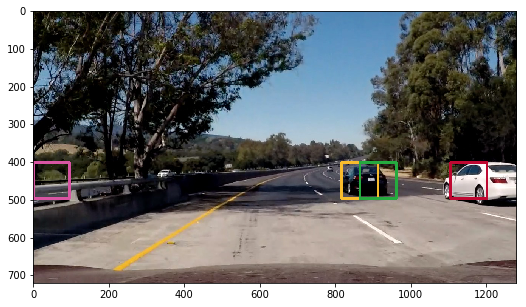

In [146]:
out_rect = draw_boxes(img, out_rectangles, color='random')
plt.figure(figsize=(10,5))
plt.imshow(out_rect)

1. Number of rectangles detected is 39 with configs of (ystart, ystop, scale)=(400,464,1)
2. Number of rectangles detected is 39 with configs of (ystart, ystop, scale)=(416,480,1)


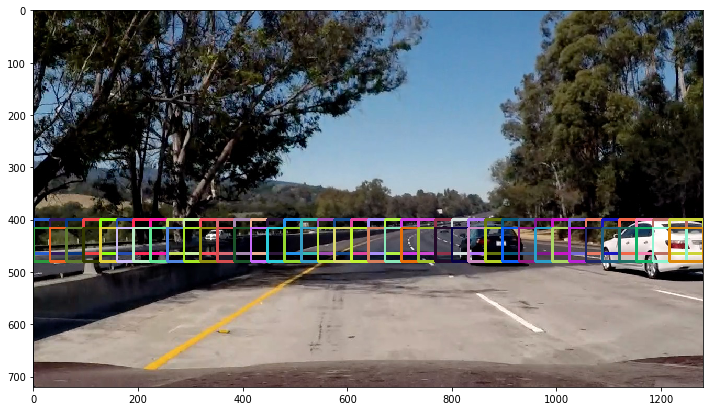

In [147]:
## Possible search areas
# Due to the sizes of the cars are based on the distance from the current camera, the size is varied. 
# find_cars method is called with different ystart, ystop, scale. 

# parameters
img = mpimg.imread('test_images/test5.jpg')

svc = clf # a trained classifier
X_scaler = None
cspace = 'YUV' # RGB, HSV, HLS, LUV, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # 0, 1, 2, ALL
spatial_size= None
hist_bins = None

all_rectangles = True

rectangles = []

configs = [[400,464,1.0], [416,480,1.0]]
           
i=0
for (ystart, ystop, scale) in configs:
    i+=1
    out_rectangles = find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, all_rectangles)
    rectangles.append(out_rectangles)
    print('%d. Number of rectangles detected is %d with configs of (ystart, ystop, scale)=(%d,%d,%d)' % (i, len(out_rectangles), ystart, ystop, scale))

rects = [x for sublist in rectangles for x in sublist] 
out_rect1 = draw_boxes(img, rects, color='random', thick=3)
plt.figure(figsize=(12,10))
plt.imshow(out_rect1)


1. Number of rectangles detected is 19 with configs of (ystart, ystop, scale)=(400,535,2)
2. Number of rectangles detected is 19 with configs of (ystart, ystop, scale)=(464,599,2)


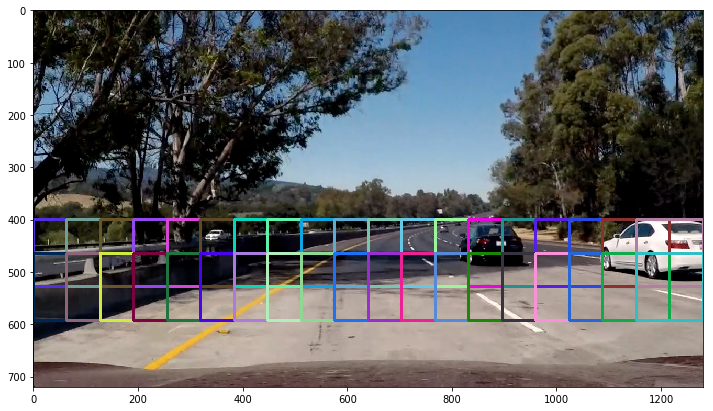

In [148]:
all_rectangles = True

rectangles = []

configs = [[400,535,2.0], [464,599,2.0]]
           
i=0
for (ystart, ystop, scale) in configs:
    i+=1
    out_rectangles = find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, all_rectangles)
    rectangles.append(out_rectangles)
    print('%d. Number of rectangles detected is %d with configs of (ystart, ystop, scale)=(%d,%d,%d)' % (i, len(out_rectangles), ystart, ystop, scale))

rects = [x for sublist in rectangles for x in sublist] 
out_rect1 = draw_boxes(img, rects, color='random', thick=3)
plt.figure(figsize=(12,10))
plt.imshow(out_rect1)

1. Number of rectangles detected is 15 with configs of (ystart, ystop, scale)=(400,590,2)
2. Number of rectangles detected is 15 with configs of (ystart, ystop, scale)=(464,654,2)


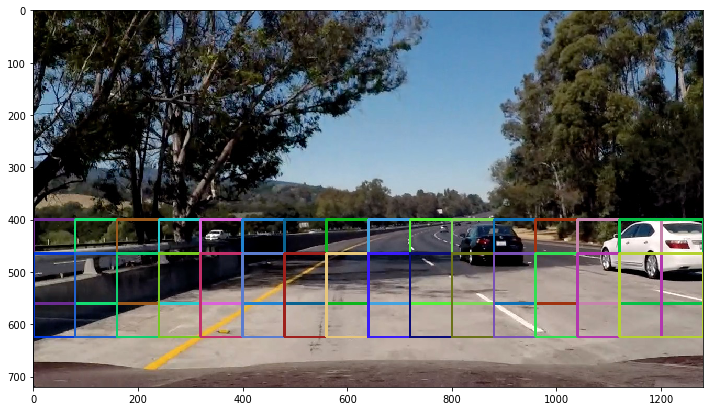

In [149]:
all_rectangles = True

rectangles = []

configs = [[400,590,2.5], [464,654,2.5]]
           
i=0
for (ystart, ystop, scale) in configs:
    i+=1
    out_rectangles = find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, all_rectangles)
    rectangles.append(out_rectangles)
    print('%d. Number of rectangles detected is %d with configs of (ystart, ystop, scale)=(%d,%d,%d)' % (i, len(out_rectangles), ystart, ystop, scale))

rects = [x for sublist in rectangles for x in sublist] 
out_rect1 = draw_boxes(img, rects, color='random', thick=3)
plt.figure(figsize=(12,10))
plt.imshow(out_rect1)

1. Number of rectangles detected is 2 with configs of (ystart, ystop, scale)=(400,464,1)
2. Number of rectangles detected is 0 with configs of (ystart, ystop, scale)=(464,528,1)


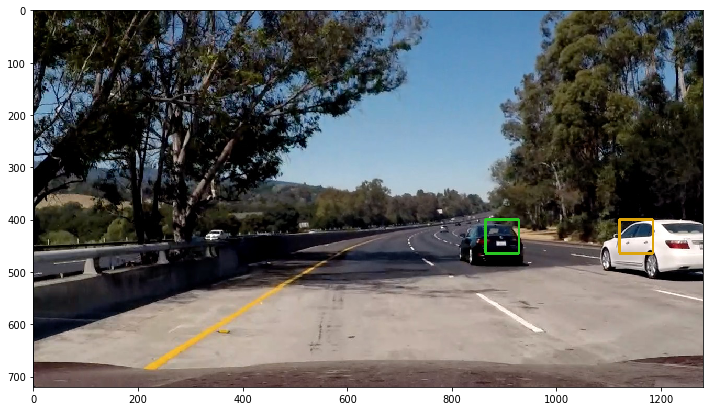

In [150]:
all_rectangles = False
rectangles = []
configs = [[400,464,1.0], [464,528,1.0]]
           
i=0
for (ystart, ystop, scale) in configs:
    i+=1
    out_rectangles = find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, all_rectangles)
    rectangles.append(out_rectangles)
    print('%d. Number of rectangles detected is %d with configs of (ystart, ystop, scale)=(%d,%d,%d)' % (i, len(out_rectangles), ystart, ystop, scale))

rects = [x for sublist in rectangles for x in sublist] 
out_rect1 = draw_boxes(img, rects, color='random', thick=3)
plt.figure(figsize=(12,10))
plt.imshow(out_rect1)

1. Number of rectangles detected is 2 with configs of (ystart, ystop, scale)=(400,464,1)
2. Number of rectangles detected is 1 with configs of (ystart, ystop, scale)=(416,480,1)
3. Number of rectangles detected is 4 with configs of (ystart, ystop, scale)=(400,496,1)
4. Number of rectangles detected is 0 with configs of (ystart, ystop, scale)=(432,528,1)
5. Number of rectangles detected is 3 with configs of (ystart, ystop, scale)=(400,528,2)
6. Number of rectangles detected is 0 with configs of (ystart, ystop, scale)=(432,560,2)
7. Number of rectangles detected is 0 with configs of (ystart, ystop, scale)=(400,596,3)
8. Number of rectangles detected is 0 with configs of (ystart, ystop, scale)=(464,660,3)


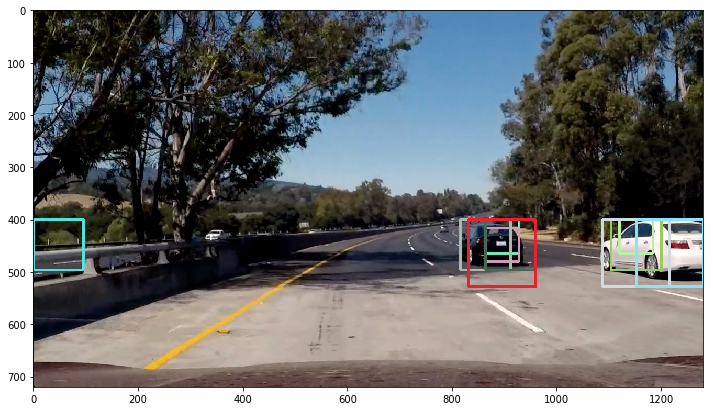

In [151]:
# Combining different sliding window searches.
# parameters
img = mpimg.imread('test_images/test5.jpg')

svc = clf # a trained classifier
X_scaler = None
cspace = 'YUV' # RGB, HSV, HLS, LUV, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # 0, 1, 2, ALL
spatial_size= None
hist_bins = None

all_rectangles = False

rectangles = []

# configure different sliding window searches.
configs = [[400,464,1.0], [416,480,1.0], [400,496,1.5], [432,528,1.5], [400,528,2.0], [432,560,2.0], [400,596,3.5], [464,660,3.5]]
           
i=0
for (ystart, ystop, scale) in configs:
    i+=1
    out_rectangles = find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, all_rectangles)
    rectangles.append(out_rectangles)
    print('%d. Number of rectangles detected is %d with configs of (ystart, ystop, scale)=(%d,%d,%d)' % (i, len(out_rectangles), ystart, ystop, scale))


rectangles = [x for sublist in rectangles for x in sublist] 
out_rect1 = draw_boxes(img, rectangles, color='random', thick=3)
plt.figure(figsize=(12,10))
plt.imshow(out_rect1)

In [152]:
### Heat Map
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap # updated heatmap

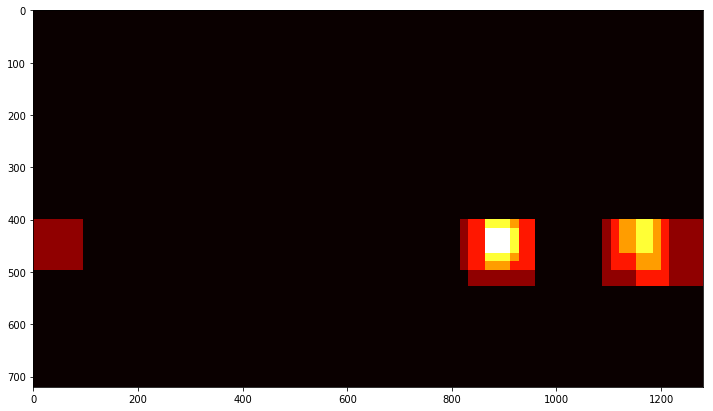

In [153]:
out_heatmap = np.zeros_like(img[:,:,0])
out_heatmap = add_heat(out_heatmap, rectangles)

plt.figure(figsize=(12,10))
plt.imshow(out_heatmap, cmap='hot')

In [154]:
# apply threshold
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

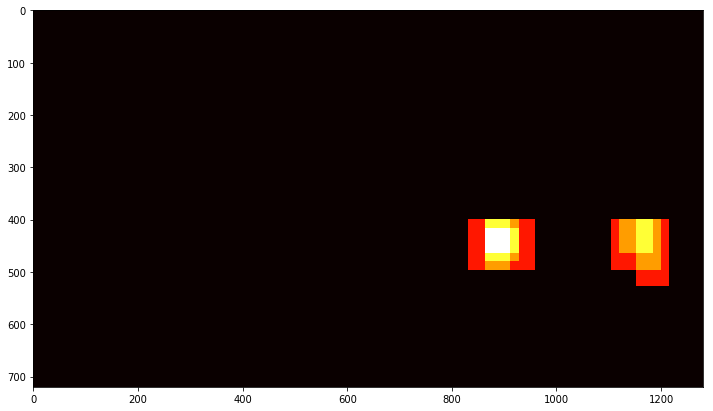

In [155]:
threshold_hm = 1
out_thresh_heatmap = apply_threshold(out_heatmap, threshold_hm)

plt.figure(figsize=(12,10))
plt.imshow(out_heatmap, cmap='hot')

2 cars found


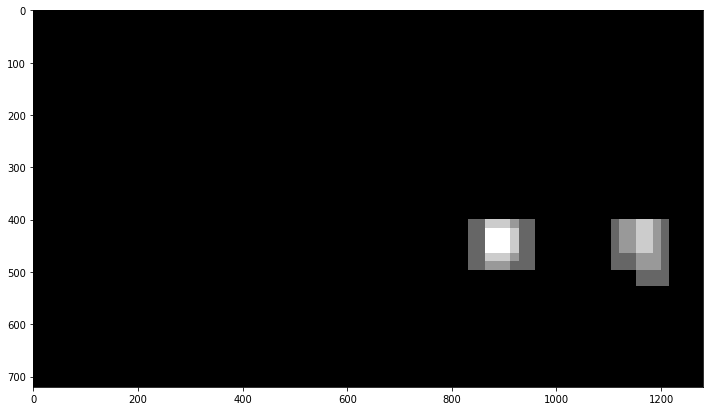

In [156]:
# use scipy 
labels = label(out_thresh_heatmap)

plt.figure(figsize=(12,10))
plt.imshow(out_heatmap, cmap='gray')
print(labels[1], 'cars found')

In [157]:
# draw boxes
def draw_labeled_bboxes(img, labels, color=(0,0,255), thick=6):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        randcolor = False
        rects.append(bbox)
        if randcolor or color == 'random': 
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            randcolor = True
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    return img, rects

2 cars detected


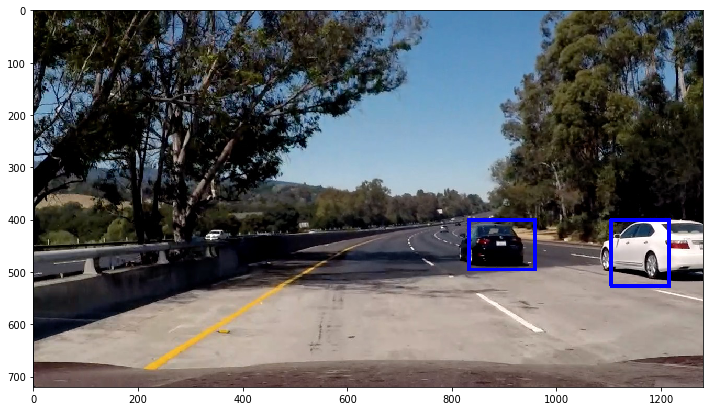

In [158]:
# Find final boxes from heatmap using label function
# labels = label(out_thresh_heatmap)
draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)

plt.figure(figsize=(12,10))
plt.imshow(draw_img, cmap='gray')
print(labels[1], 'cars detected')

**Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
**

In [159]:
def pipeline_process(img):
    svc = clf # a trained classifier of SVM
    #svc = clf_dt # a trained classifier of decision tree
    X_scaler = None
    cspace = 'YUV' # RGB, HSV, HLS, LUV, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # 0, 1, 2, ALL
    spatial_size= None
    hist_bins = None

    all_rectangles = False

    rectangles = []

    # configure different sliding window searches.
    # scale <1.0 introduces more falsely positives. I have tested to [400,464,0.5], it introduced 18 rectangles.
    configs = [[400,464,1.0], [416,480,1.0], [400,496,1.5], [432,528,1.5], [400,528,2.0], [432,560,2.0], [400,596,3.5], [464,660,3.5]]

    for (ystart, ystop, scale) in configs:
        out_rectangles = find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, all_rectangles)
        rectangles.append(out_rectangles)
    
    rectangles = [x for sublist in rectangles for x in sublist] 
    # add heatmap
    out_heatmap = np.zeros_like(img[:,:,0])
    out_heatmap = add_heat(out_heatmap, rectangles)
    # add threshold
    out_heatmap = apply_threshold(out_heatmap, 1)
    labels = label(out_heatmap)
    # draw boxes
    #draw_image, rects = draw_labeled_bboxes(np.copy(img), labels, color='random', thick=3)
    draw_image, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_image
    

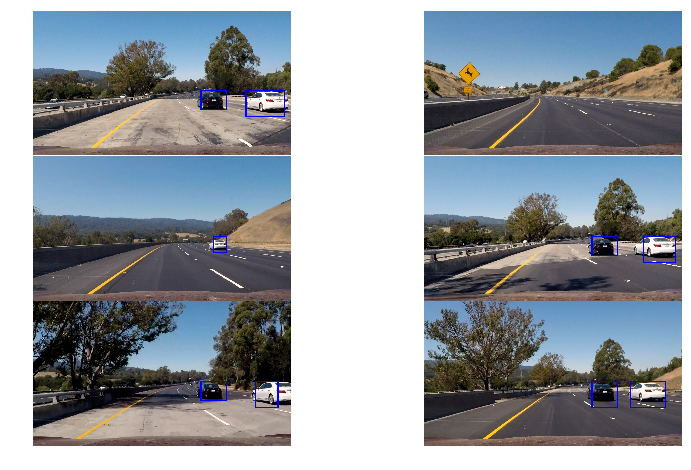

In [160]:
# testing
test_images = glob.glob('test_images/t*.jpg')

fig, ax = plt.subplots(3, 2, figsize=(14,8))
fig.subplots_adjust(hspace = .004, wspace=.002)
ax = ax.ravel()

for i, imgx in enumerate(test_images):
    output = pipeline_process(mpimg.imread(imgx))
    ax[i].imshow(output)
    ax[i].axis('off')


In [161]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_out_file = 'test_video_out_without_detection1.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(pipeline_process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out_without_detection1.mp4
[MoviePy] Writing video test_video_out_without_detection1.mp4



 97%|█████████▋| 38/39 [00:09<00:00,  3.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_without_detection1.mp4 

CPU times: user 8.94 s, sys: 1.45 s, total: 10.4 s
Wall time: 10.7 s


In [162]:
test_out_file = 'project_video_out_without_detection1.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline_process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out_without_detection1.mp4
[MoviePy] Writing video project_video_out_without_detection1.mp4



 12%|█▏        | 152/1261 [00:37<04:35,  4.03it/s]


 24%|██▍       | 303/1261 [01:15<03:56,  4.04it/s]


 36%|███▌      | 454/1261 [01:52<03:13,  4.17it/s]


 48%|████▊     | 605/1261 [02:28<02:36,  4.19it/s]


 60%|█████▉    | 756/1261 [03:08<02:07,  3.95it/s]


 72%|███████▏  | 907/1261 [03:46<01:26,  4.08it/s]


 84%|████████▍ | 1057/1261 [04:24<00:54,  3.72it/s]


 96%|█████████▌| 1205/1261 [05:02<00:13,  4.06it/s]


100%|█████████▉| 1260/1261 [05:15<00:00,  3.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_without_detection1.mp4 

CPU times: user 4min 46s, sys: 45.7 s, total: 5min 32s
Wall time: 5min 16s


**Estimate a bounding box for vehicles detected.**

In [163]:
# Define a class to store data from video
class Vehicle_Detect():
    
    def __init__(self):
        # history of rectangles previous n frames
        self.boundingbox = 15
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > self.boundingbox:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-self.boundingbox:]


In [164]:
def pipeline_process_update(img):
    svc = clf # a trained classifier of SVM
    #svc = clf_dt # a trained classifier of decision tree
    X_scaler = None
    cspace = 'YUV' # RGB, HSV, HLS, LUV, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # 0, 1, 2, ALL
    spatial_size= None
    hist_bins = None

    all_rectangles = False

    rectangles = []

    # configure different sliding window searches.
    # scale <1.0 introduces more falsely positives. I have tested to [400,464,0.5], it introduced 18 rectangles.
    configs = [[400,464,1.0], [416,480,1.0], [400,496,1.5], [432,528,1.5], [400,528,2.0], [432,560,2.0], [400,596,3.5], [464,660,3.5]]

    for (ystart, ystop, scale) in configs:
        out_rectangles = find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, all_rectangles)
        rectangles.append(out_rectangles)
    
    rectangles = [x for sublist in rectangles for x in sublist] 
    
    # add detected rectangles to the history list
    if len(rectangles) > 0:
        detected.add_rects(rectangles)
    
    # add heatmap
    out_heatmap = np.zeros_like(img[:,:,0])
    for rectset in detected.prev_rects:
        out_heatmap = add_heat(out_heatmap, rectset)
        
    # add threshold
    out_heatmap = apply_threshold(out_heatmap, 1+ len(detected.prev_rects)//2)
    labels = label(out_heatmap)
    # draw boxes
#     draw_image, rects = draw_labeled_bboxes(np.copy(img), labels, color='random', thick=6)
    draw_image, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_image

In [165]:
detected = Vehicle_Detect()
detected.boundingbox = 22

test_out_file2 = 'test_video_out_with_detection_bluecolor_22.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(pipeline_process_update)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_with_detection_bluecolor_22.mp4
[MoviePy] Writing video test_video_out_with_detection_bluecolor_22.mp4



 97%|█████████▋| 38/39 [00:09<00:00,  3.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_with_detection_bluecolor_22.mp4 

CPU times: user 9.02 s, sys: 1.49 s, total: 10.5 s
Wall time: 10.8 s


In [166]:
detected = Vehicle_Detect()
detected.boundingbox = 22

test_out_file = 'project_video_out_with_detection_bluecolor_22.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline_process_update)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out_with_detection_bluecolor_22.mp4
[MoviePy] Writing video project_video_out_with_detection_bluecolor_22.mp4



 12%|█▏        | 152/1261 [00:38<04:41,  3.94it/s]


 24%|██▍       | 303/1261 [01:17<04:33,  3.50it/s]


 36%|███▌      | 454/1261 [01:57<03:35,  3.75it/s]


 48%|████▊     | 605/1261 [02:36<02:47,  3.92it/s]


 60%|█████▉    | 756/1261 [03:15<02:10,  3.86it/s]


 72%|███████▏  | 907/1261 [03:53<01:24,  4.17it/s]


 84%|████████▍ | 1057/1261 [04:33<00:51,  3.98it/s]


 96%|█████████▌| 1205/1261 [05:12<00:13,  4.08it/s]


100%|█████████▉| 1260/1261 [05:26<00:00,  3.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_with_detection_bluecolor_22.mp4 

CPU times: user 4min 55s, sys: 46.3 s, total: 5min 41s
Wall time: 5min 27s


In [167]:
detected = Vehicle_Detect()
detected.boundingbox = 22

test_out_file = 'challenge_video_out_with_detection_bluecolor_22.mp4'
clip_test = VideoFileClip('challenge_video.mp4')
clip_test_out = clip_test.fl_image(pipeline_process_update)
%time clip_test_out.write_videofile(test_out_file, audio=False)



[MoviePy] >>>> Building video challenge_video_out_with_detection_bluecolor_22.mp4
[MoviePy] Writing video challenge_video_out_with_detection_bluecolor_22.mp4



 32%|███▏      | 155/485 [00:38<01:26,  3.84it/s]


 64%|██████▎   | 309/485 [01:17<00:45,  3.85it/s]


 95%|█████████▌| 463/485 [01:57<00:05,  3.84it/s]


100%|██████████| 485/485 [02:03<00:00,  3.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out_with_detection_bluecolor_22.mp4 

CPU times: user 1min 51s, sys: 17.7 s, total: 2min 9s
Wall time: 2min 3s
